# Basic Preprocessing

This notebook will:
- Deskew and scale numerical features  
- One-hot encode categorical features   
- Visualize transformation of three features

In [110]:
library(dplyr)
library(moments)
library(repr)
library(ggplot2)
library(onehot)
library(gridExtra)

In [111]:
### Loading in Data Set - Refer to 01. EDA for more details
ames_URL <- 'https://ww2.amstat.org/publications/jse/v19n3/decock/AmesHousing.txt'
ames <- read.table(url(ames_URL), sep = '\t', header = TRUE)

ames$Order <- NULL
ames$PID <- NULL

to_be_factors <- c("MS.SubClass", "Overall.Qual", "Overall.Cond", "Bsmt.Full.Bath", "Bsmt.Half.Bath", "Full.Bath", 
                   "Half.Bath", "Bedroom.AbvGr", "Kitchen.AbvGr", "TotRms.AbvGrd", "Fireplaces", "Garage.Cars", "Mo.Sold",
                   "Yr.Sold", "Year.Built", "Year.Remod.Add")
ames[to_be_factors] <- lapply(ames[to_be_factors], factor)

ames$Lot.Frontage[is.na(ames$Lot.Frontage)] <- mean(ames$Lot.Frontage, na.rm=TRUE)
ames$Mas.Vnr.Area[is.na(ames$Mas.Vnr.Area)] <- mean(ames$Mas.Vnr.Area, na.rm=TRUE)
ames$Garage.Yr.Blt[is.na(ames$Garage.Yr.Blt)] <- mean(ames$Garage.Yr.Blt, na.rm=TRUE)

empty_means_without <-c("Alley","Bsmt.Qual","Bsmt.Cond","Bsmt.Exposure","BsmtFin.Type.1", "BsmtFin.Type.2", "Fireplace.Qu",
                        "Garage.Type","Garage.Finish", "Garage.Qual","Garage.Cond","Pool.QC","Fence","Misc.Feature")

replace_empty_with_without <- function(feature) {
    levels(feature) <- c(levels(feature), "Without")
    feature[is.na(feature)] <- "Without"
    return(feature)
}

for (feature in empty_means_without) {
    ames[,feature] <- replace_empty_with_without(ames[,feature])
}

ames <- na.omit(ames)

### Original Dataset Statistics

The following looks at the mean, standard deviation, skew and kurtosis of the Ames, Iowa dataset.

In [112]:
num_vars <- sapply(ames, is.numeric)
ames_stats <- data.frame(Feature = colnames(ames[num_vars]))

options(scipen=10000)
ames_stats['Mean'] <- sapply(ames[num_vars], mean)
ames_stats['SD'] <- sapply(ames[num_vars], sd)
ames_stats['Skewness'] <- sapply(ames[num_vars], skewness)
ames_stats['Kurtosis'] <- sapply(ames[num_vars], kurtosis)
ames_stats

Feature,Mean,SD,Skewness,Kurtosis
Lot.Frontage,69.202613,21.29919,1.6454681,17.143531
Lot.Area,10137.138367,7854.13621,12.9235464,271.297099
Mas.Vnr.Area,102.001239,178.46957,2.6143346,12.355049
BsmtFin.SF.1,442.744790,455.66887,1.4152473,9.843781
BsmtFin.SF.2,49.756406,169.22128,4.1362264,21.731777
Bsmt.Unf.SF,559.538435,439.49869,0.9220645,3.405718
Total.Bsmt.SF,1052.039631,440.32207,1.1605006,12.142948
X1st.Flr.SF,1158.813119,388.94276,1.4003810,9.532848
X2nd.Flr.SF,335.497096,428.40465,0.8661617,2.584711
Low.Qual.Fin.SF,4.681585,46.33400,12.1056351,178.121524


## Standardizing and Deskewing the Data

Applying a log transformation to the original data and then standardizing it will pull the outliers closer to the mean, and thus, reducing skewness.

In [113]:
ames_scaled <- data.frame(scale(log(ames[num_vars] + 1)))
ames_stats['Mean_Scaled'] <- sapply(ames_scaled, mean)
ames_stats['SD_Scaled'] <- sapply(ames_scaled, sd)
ames_stats['Skewness_Scaled'] <- sapply(ames_scaled, skewness)
ames_stats['Kurtosis_scaled'] <- sapply(ames_scaled, kurtosis)
ames_stats

Feature,Mean,SD,Skewness,Kurtosis,Mean_Scaled,SD_Scaled,Skewness_Scaled,Kurtosis_scaled
Lot.Frontage,69.202613,21.29919,1.6454681,17.143531,-0.000000000000000341991573,1,-1.01471310,6.098792
Lot.Area,10137.138367,7854.13621,12.9235464,271.297099,-0.000000000000001069952572,1,-0.50984841,6.675537
Mas.Vnr.Area,102.001239,178.46957,2.6143346,12.355049,0.000000000000000043420908,1,0.50761398,1.386115
BsmtFin.SF.1,442.744790,455.66887,1.4152473,9.843781,-0.000000000000000116782798,1,-0.62240336,1.541294
BsmtFin.SF.2,49.756406,169.22128,4.1362264,21.731777,0.000000000000000008608702,1,2.44724273,7.170566
Bsmt.Unf.SF,559.538435,439.49869,0.9220645,3.405718,-0.000000000000000038797415,1,-2.15061180,6.929870
Total.Bsmt.SF,1052.039631,440.32207,1.1605006,12.142948,0.000000000000000120851742,1,-4.98818404,28.875499
X1st.Flr.SF,1158.813119,388.94276,1.4003810,9.532848,0.000000000000001202476887,1,0.04596603,3.114125
X2nd.Flr.SF,335.497096,428.40465,0.8661617,2.584711,-0.000000000000000047019000,1,0.30985572,1.116775
Low.Qual.Fin.SF,4.681585,46.33400,12.1056351,178.121524,-0.000000000000000003526296,1,8.56988462,75.397022


After deskewing and scaling the data, most features' skewness decreased. Only Bsmt.Unf.SF, Total.Bsmt.SF, Garage.Yr.Blt, and Garage.Area did not.

## One-Hot Encode Categorical Variables

One hot encoding is a representation of categorical variables as binary vectors so it works better with classification and regression algorithms. These are often times called dummy variables.

In [114]:
cat_vars <- sapply(ames, is.factor)
ames_onehot <- onehot(ames[cat_vars])

Warning message:
"Variables excluded for having levels > max_levels: MS.SubClassVariables excluded for having levels > max_levels: NeighborhoodVariables excluded for having levels > max_levels: Year.BuiltVariables excluded for having levels > max_levels: Year.Remod.AddVariables excluded for having levels > max_levels: Exterior.1stVariables excluded for having levels > max_levels: Exterior.2ndVariables excluded for having levels > max_levels: TotRms.AbvGrdVariables excluded for having levels > max_levels: Mo.Sold"

## Visualize Transformations

Let's look at the deskewed and scaled transformation of our target variable, Sale Price.

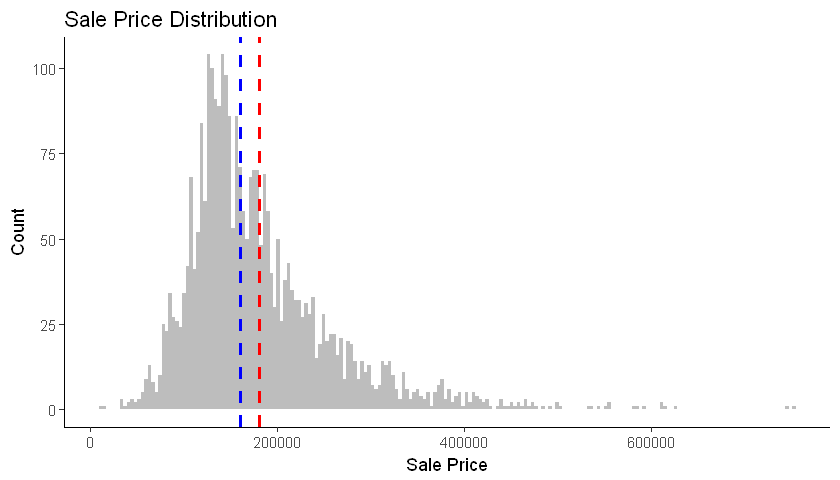

In [150]:
options(repr.plot.height = 4)
qplot(ames$SalePrice, geom="histogram", bins=200, alpha=I(.4)) +
        geom_vline(aes(xintercept=mean(ames$SalePrice)), color="red", linetype="dashed", size=1) +
        geom_vline(aes(xintercept=median(ames$SalePrice)), color="blue", linetype="dashed", size=1) +
        ggtitle("Sale Price Distribution") + 
        xlab("Sale Price") +
        ylab("Count")

### Other Variables

In [136]:
special_plot2 <- function (feature1, feature2) {
    
    p1 <- qplot(feature1, geom="histogram", bins=200, alpha=I(.4),) +
        geom_vline(aes(xintercept=mean(feature1)), color="red", linetype="dashed", size=1) +
        geom_vline(aes(xintercept=median(feature1)), color="blue", linetype="dashed", size=1) +
        ggtitle(paste(" Distribution of", deparse(substitute(feature1)))) + 
        theme(plot.title = element_text(size=10, face = "bold"), text = element_text(size=8)) +
        xlab(deparse(substitute(feature1))) +
        ylab("Count")
    
    
    p2 <- qplot(feature2, geom="histogram", bins=200, alpha=I(.4),)+
        geom_vline(aes(xintercept=mean(feature2)), color="red", linetype="dashed", size=1)+
        geom_vline(aes(xintercept=median(feature2)), color="blue", linetype="dashed", size=1)+
        ggtitle(paste(" Distribution of", deparse(substitute(feature2)))) + 
        theme(plot.title = element_text(size=10, face = "bold"), text = element_text(size=8)) +
        xlab(deparse(substitute(feature2))) +
        ylab("Count")
    
    grid.arrange(p1, p2, ncol=2)
}

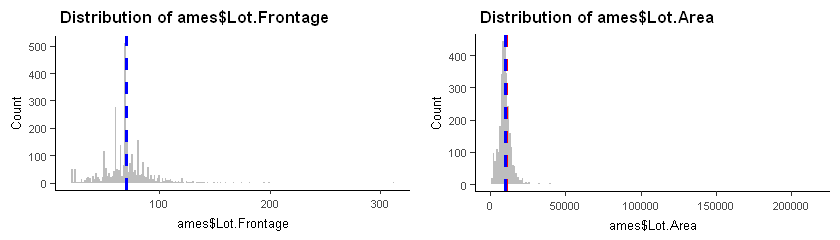

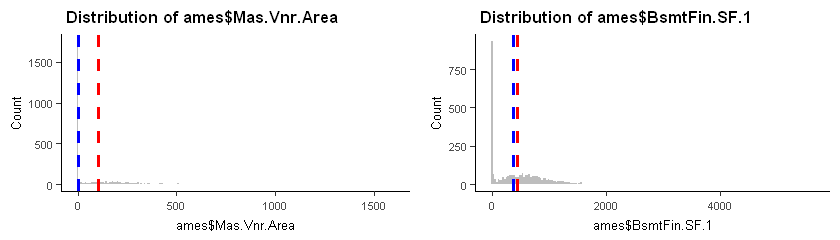

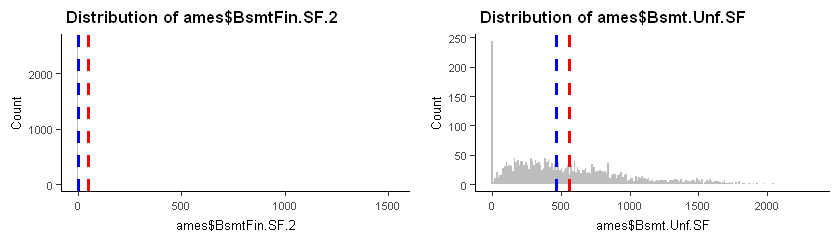

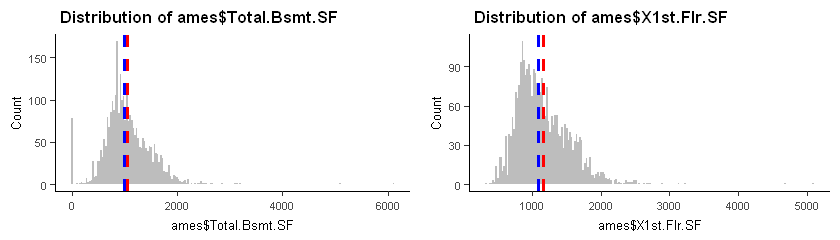

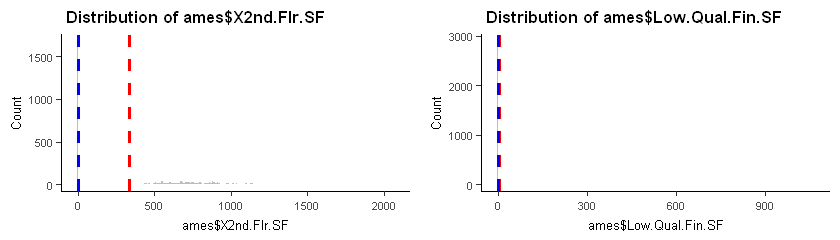

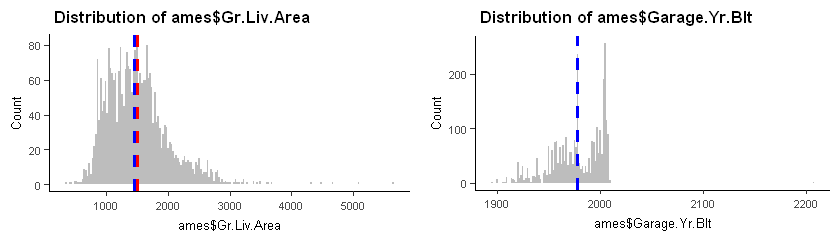

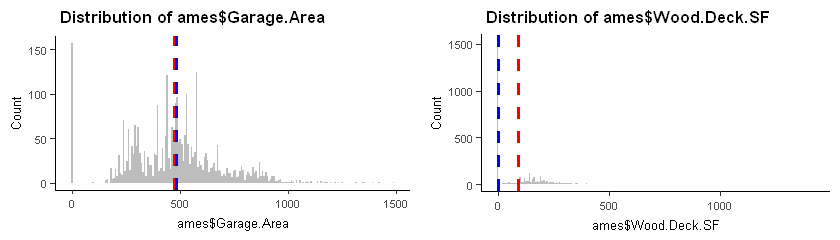

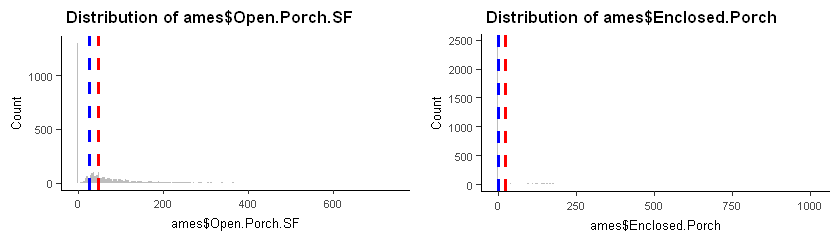

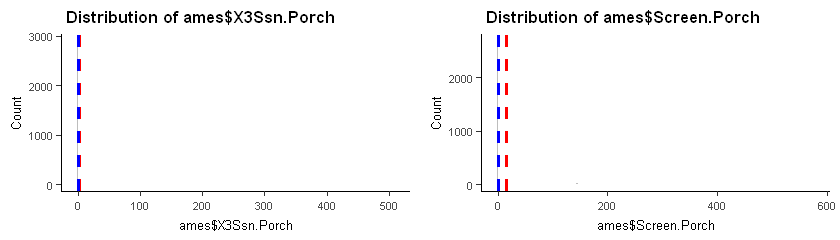

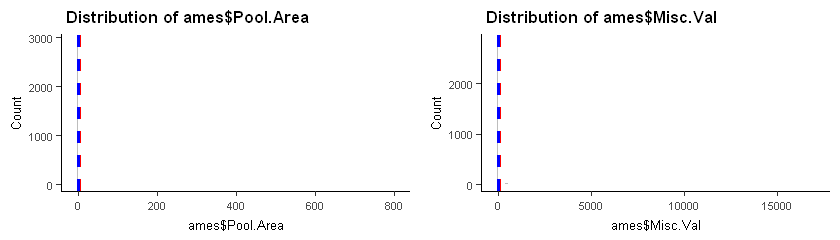

In [137]:
options(repr.plot.height = 2)
theme_set(theme_classic())
special_plot2(ames$Lot.Frontage, ames$Lot.Area)
special_plot2(ames$Mas.Vnr.Area, ames$BsmtFin.SF.1)
special_plot2(ames$BsmtFin.SF.2, ames$Bsmt.Unf.SF)
special_plot2(ames$Total.Bsmt.SF, ames$X1st.Flr.SF)
special_plot2(ames$X2nd.Flr.SF, ames$Low.Qual.Fin.SF)
special_plot2(ames$Gr.Liv.Area, ames$Garage.Yr.Blt)
special_plot2(ames$Garage.Area, ames$Wood.Deck.SF)
special_plot2(ames$Open.Porch.SF, ames$Enclosed.Porch)
special_plot2(ames$X3Ssn.Porch, ames$Screen.Porch)
special_plot2(ames$Pool.Area, ames$Misc.Val)

From these distribution charts, you can see that most variables are right skewed.